In [8]:
import itertools

import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
sys.path.append('../')
from src.analyze.correlations import get_corr_df, plot_scatterplots_for_metric

In [9]:
# change this path to the results folder
RESULT_FOLDER = '.../data/results'
RESULT_VARIANT = 'final_results'

DATASETS = ['Movielens-1m', 'Movielens-20m', 'Beauty', 'Sports',
            'BeerAdvocate', 'Diginetica', 'Zvuk', 'YooChoose']
QUANTILES = ['q09']
VALIDATION_TYPE = 'val_by_user'
MODELS = ['SASRec', 'GRU4Rec', 'BERT4Rec']

## Load data

In [10]:
def load_experiment_results(datasets, quantiles, val_type, models, results_folder, results_variant):
    """
    Load experiment results for multiple datasets, quantiles, and models,
    and combine them into a dictionary of DataFrames by split type.

    Args:
        datasets: List of dataset names
        quantiles: List of quantile values
        val_type: Validation type
        models: List of model names
        results_folder: Base results directory
        results_variant: Results variant (subfolder name)

    Returns:
        Dictionary where keys are split types and values are concatenated DataFrames
        from all datasets, quantiles, and models.
    """

    data = defaultdict(list)

    for dataset in datasets:
        for quantile in quantiles:
            for model_name in models:
                global_timesplit_base_path = os.path.join(
                    results_folder,
                    f'global_timesplit/{val_type}/{dataset}/{quantile}/{model_name}/',
                    results_variant)

                # Paths for different split types
                # should be no '-' in the key
                split_paths = {
                    'LLO': os.path.join(results_folder, f'leave-one-out/{dataset}/{model_name}/',
                                        results_variant, 'test.csv'),
                    'Succ_global': os.path.join(global_timesplit_base_path, 'test_successive_global.csv'),
                    'Succ_user': os.path.join(global_timesplit_base_path, 'test_successive_userbased.csv'),
                    'GT_last': os.path.join(global_timesplit_base_path, 'test_last.csv'),
                    'GT_first': os.path.join(global_timesplit_base_path, 'test_first.csv'),
                    'GT_random': os.path.join(global_timesplit_base_path, 'test_random.csv'),
                    'GT_all_items': os.path.join(global_timesplit_base_path, 'test_all_items_s.csv'),
                    'GT_all_items_w': os.path.join(global_timesplit_base_path, 'test_all_items_s_warm.csv'),
                }

                for split_type, path in split_paths.items():
                    # if os.path.exists(path):
                    df = pd.read_csv(path)
                    df['dataset'] = dataset
                    df['quantile'] = quantile
                    df['model'] = model_name
                    data[split_type].append(df)

    # Concatenate DataFrames for each split type
    data = {split_type: pd.concat(dfs, ignore_index=True)
            for split_type, dfs in data.items()}

    # Workaround because analysis doesn't work if there are duplicated grid_points!
    if len(models) > 1 or len(datasets) > 1 or len(quantiles) > 1:
        for split_type in data.keys():
            data[split_type]['grid_point'] = data[split_type].index

    return data

In [11]:
data = load_experiment_results(DATASETS, QUANTILES, VALIDATION_TYPE,
                               MODELS, RESULT_FOLDER, RESULT_VARIANT)

## Plot correlations at different K

In [13]:
ANCHOR_SPLIT = 'Succ_user'
OTHER_SPLITS = [
    'LLO',
    'GT_last',
    'GT_first',
    'GT_random',
    # 'GT_all_items'
]

In [14]:
anchor_data = data[ANCHOR_SPLIT]
filtered_data = {key: value for key, value in data.items()
                 if key in OTHER_SPLITS}

In [15]:
METRIC = 'NDCG'
CORR_TYPE = 'kendall'  # kendall, spearman, pearson

In [16]:
split_corr_dfs = {}
for split, df in filtered_data.items():

    corr = {}
    for dataset in DATASETS:
        anchor_df_dataset = anchor_data[anchor_data.dataset == dataset]
        df_dataset = df[df.dataset == dataset]
        corr[dataset] = get_corr_df(anchor_df_dataset, df_dataset, metrics=[METRIC]).loc[CORR_TYPE]

    split_corr_dfs[f'{ANCHOR_SPLIT}-{split}'] = pd.DataFrame(corr)
    split_corr_dfs[f'{ANCHOR_SPLIT}-{split}'].drop('NDCG@1', axis=0, inplace=True)

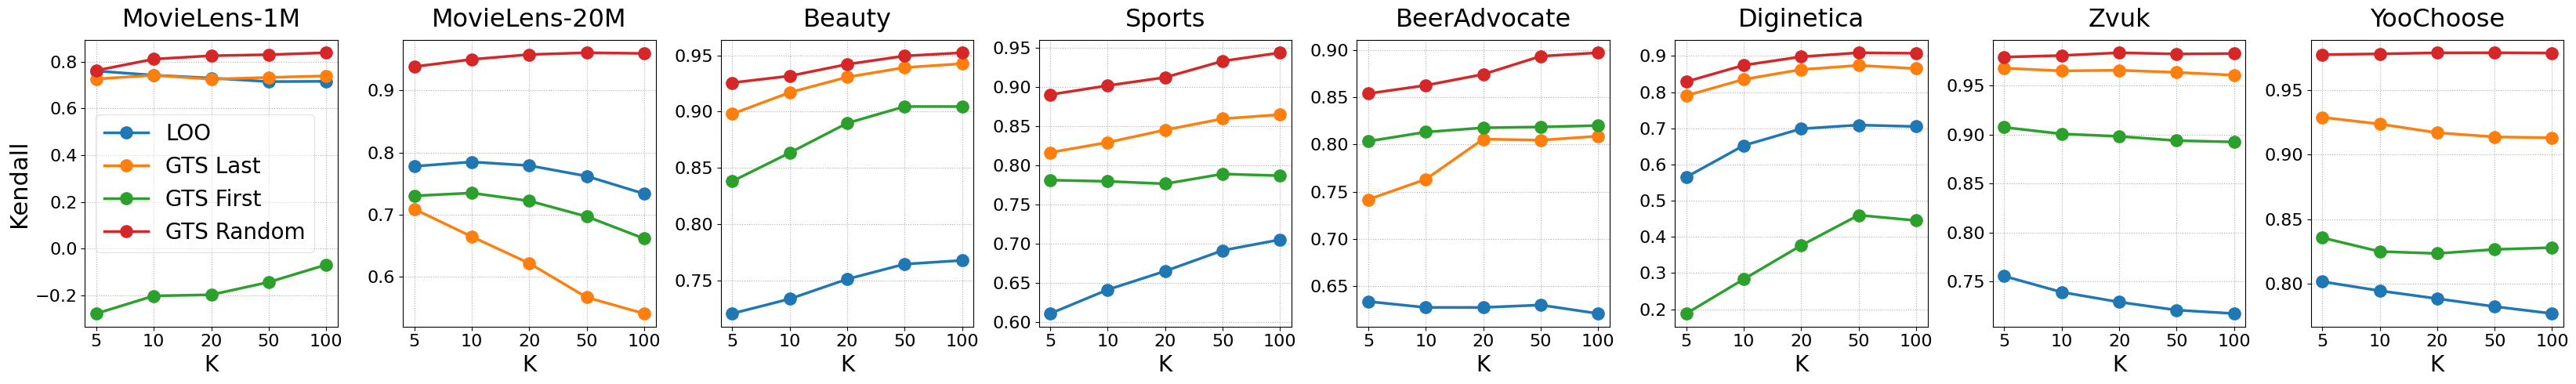

In [ ]:
dataset_names = {
    'Movielens-1m': 'MovieLens-1M',
    'Movielens-20m': 'MovieLens-20M',
    # add other mappings if necessary
}


fig, axes = plt.subplots(1, len(DATASETS), figsize=(33, 5), squeeze=True)

for i, dataset in enumerate(DATASETS):
    ax = axes[i]
    display_name = dataset_names.get(dataset, dataset)
    for split_name, df in split_corr_dfs.items():
        values = df[dataset].values
        cutoffs = [x.split('@')[1] for x in df.index]
        x_positions = range(len(cutoffs))
        ax.plot(x_positions, values, marker='o', ms=11, label=split_name, linewidth=2.5)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(cutoffs)
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_title(display_name, fontsize=23, pad=12)

    ax.set_xlabel("K", fontsize=20)
    if i == 0:
        ax.set_ylabel(f"{CORR_TYPE.title()}", fontsize=22)

        handles, labels = ax.get_legend_handles_labels()
        legend_labels = ['LOO', 'GTS Last', 'GTS First', 'GTS Random']
        ax.legend(
            handles,
            legend_labels,
            loc='center left',
            fontsize=20,
            framealpha=0.5
        )

    ax.grid(True, linestyle=':', alpha=1)

plt.tight_layout()
plt.show()


In [18]:
fig.savefig('test_vs_test_corr.pdf', bbox_inches='tight', format='pdf')

## Scatterplots

In [19]:
ANCHOR_SPLIT = 'Succ_user'
OTHER_SPLITS = [
    'LLO',
    'GT_last',
    'GT_first',
    'GT_random',
    'GT_all_items'
]

In [20]:
anchor_data = data[ANCHOR_SPLIT]
filtered_data = {key: value for key, value in data.items()
                 if key in OTHER_SPLITS}

In [21]:
METRIC_NAME = 'NDCG@10'
CORR_TYPE = 'kendall'  # kendall, spearman, pearson
COLOR_BY = 'model'

# DATASETS_FOR_SCATTERPLOTS = [
#     'Movielens-1m', 'Movielens-20m', 'Beauty', 'Sports',
#     'BeerAdvocate', 'Diginetica', 'Zvuk', 'YooChoose']

DATASETS_FOR_SCATTERPLOTS = [
    'Sports','Diginetica', 'YooChoose']

SPLIT_NAMES = {
    'LLO': 'LOO',
    'GT_last': 'GTS Last',
    'GT_first': 'GTS First',
    'GT_random': 'GTS Random',
    'GT_all_items': 'GTS All'
}

In [22]:
sns.set_style('whitegrid')

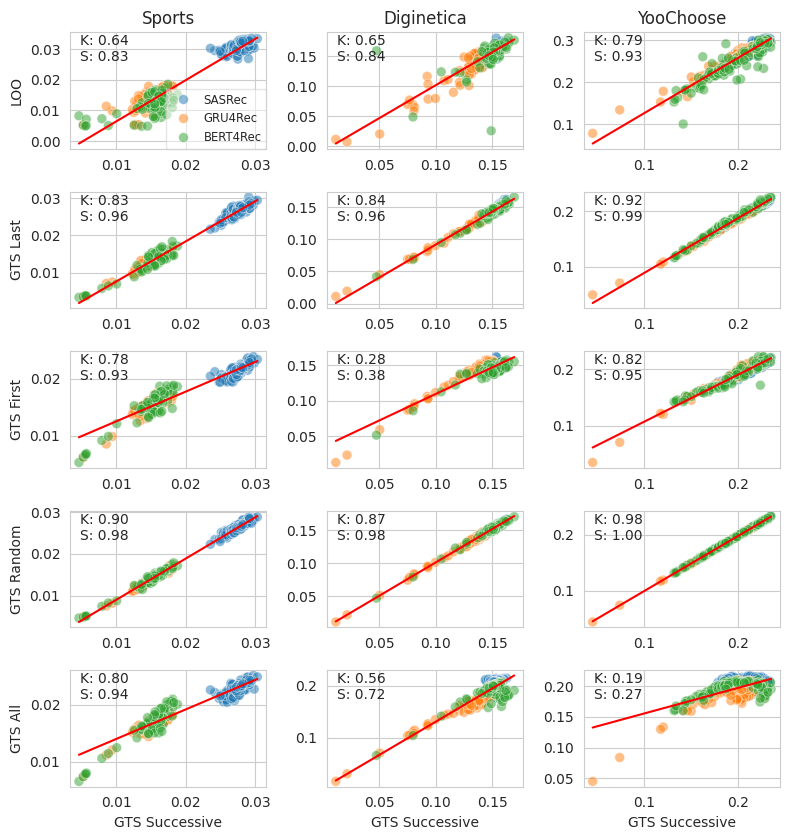

In [23]:
fig, axes = plt.subplots(nrows=5, ncols=len(DATASETS_FOR_SCATTERPLOTS), figsize=(8, 8.5))

for i, dataset in enumerate(DATASETS_FOR_SCATTERPLOTS):
    df1 = anchor_data[anchor_data.dataset == dataset]
    
    for j, (split_name, df) in enumerate(filtered_data.items()):
        df2 = df[df.dataset == dataset]

        merge_cols = ['grid_point', METRIC_NAME, COLOR_BY]
        df_merge = pd.merge(
            df1[merge_cols],
            df2[merge_cols],
            on='grid_point',
            suffixes=(f'_{ANCHOR_SPLIT}', f'_{split_name}')
        ).dropna()

        ax = axes[j, i]
        x = df_merge[f"{METRIC_NAME}_{ANCHOR_SPLIT}"].values
        y = df_merge[f"{METRIC_NAME}_{split_name}"].values
        hue = df_merge[f"{COLOR_BY}_{split_name}"]

        # Calculate correlation coefficients
        pearson = np.corrcoef(x, y)[0, 1]
        spearman = pd.Series(x).corr(pd.Series(y), method='spearman')
        kendall = pd.Series(x).corr(pd.Series(y), method='kendall')

        # Only draw legend in the very first subplot
        show_legend = (i == 0 and j == 0)
        sns.scatterplot(
            x=x, y=y, ax=ax, s=50, hue=hue,
            legend='full' if show_legend else False,
            alpha=0.5
        )

        # Add regression line
        slope, intercept = np.polyfit(x, y, 1)
        x_vals = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_vals, intercept + slope * x_vals, color='red')

        # Titles, labels, and stats text
        if i == 0:
            ax.set_ylabel(SPLIT_NAMES[split_name], fontsize=10)
        if j == 0:
            ax.set_title(dataset)
        ax.text(
            0.05, 0.75,
            f'K: {kendall:.2f}\nS: {spearman:.2f}',
            transform=ax.transAxes,
            fontsize=10
        )
        if j == 4:
            ax.set_xlabel("GTS Successive", fontsize=10)

        # If this is the first subplot, adjust its legend box
        if show_legend:
            ax.legend(
                # title=COLOR_BY,
                # bbox_to_anchor=(1.05, 1),
                loc='lower right',
                borderaxespad=0,
                fontsize=8.4,
                framealpha=0.5
            )

# plt.subplots_adjust(hspace=0.05, wspace=0.3)
plt.tight_layout()


In [24]:
fig.savefig('test_vs_test_scatterplot_vertical.pdf', bbox_inches='tight', format='pdf')

## Table with average correlations

In [25]:
# METRICS = ['NDCG@10', 'HR@10', 'MRR@10', 'COV@10']
METRICS = ['NDCG@10', 'HR@10', 'MRR@10']
CORR_TYPES = ['kendall', 'spearman']

In [26]:
# Each model considered separately

# corr_df = []
# for split, df in filtered_data.items():
#     for dataset in DATASETS:
#         for model in MODELS:
#             for metric in METRICS:
#                 anchor_df_dataset = anchor_data[(anchor_data.dataset == dataset)
#                                                 & (anchor_data.model == model)]
#                 df_dataset = df[(df.dataset == dataset) & (df.model == model)]
    
#                 col_name = metric
#                 df_merge = pd.merge(
#                     anchor_df_dataset[['grid_point', col_name]],
#                     df_dataset[['grid_point', col_name]],
#                     on='grid_point',
#                     suffixes=(f'_{ANCHOR_SPLIT}', f'_{split}')
#                 ).dropna()
    
#                 x = df_merge[f"{col_name}_{ANCHOR_SPLIT}"].values
#                 y = df_merge[f"{col_name}_{split}"].values
    
#                 corr = {
#                     'split': split,
#                     'model': model,
#                     'dataset': dataset,
#                     'metric': col_name,
#                     'pearson': np.corrcoef(x, y)[0, 1],
#                     'spearman': pd.Series(x).corr(pd.Series(y), method='spearman'),
#                     'kendall': pd.Series(x).corr(pd.Series(y), method='kendall'),
#                 }
    
#                 corr_df.append(corr)
            
# corr_df = pd.DataFrame(corr_df)

In [27]:
# Combine models

corr_df = []
for split, df in filtered_data.items():
    for dataset in DATASETS:
        for metric in METRICS:
            anchor_df_dataset = anchor_data[(anchor_data.dataset == dataset)]
            df_dataset = df[(df.dataset == dataset)]

            col_name = metric
            df_merge = pd.merge(
                anchor_df_dataset[['grid_point', col_name]],
                df_dataset[['grid_point', col_name]],
                on='grid_point',
                suffixes=(f'_{ANCHOR_SPLIT}', f'_{split}')
            ).dropna()

            x = df_merge[f"{col_name}_{ANCHOR_SPLIT}"].values
            y = df_merge[f"{col_name}_{split}"].values

            corr = {
                'split': split,
                'dataset': dataset,
                'metric': col_name,
                'pearson': np.corrcoef(x, y)[0, 1],
                'spearman': pd.Series(x).corr(pd.Series(y), method='spearman'),
                'kendall': pd.Series(x).corr(pd.Series(y), method='kendall'),
            }

            corr_df.append(corr)
        
corr_df = pd.DataFrame(corr_df)

In [28]:
mean_correlations = {}
for split in corr_df.split.unique():
    for metric in METRICS:
        condition = (corr_df.split == split) & (corr_df.metric == metric)
        mean_corr = corr_df[condition][CORR_TYPES].mean()
        mean_correlations[(split, metric)] = mean_corr

In [29]:
print(ANCHOR_SPLIT)
mean_correlations = pd.DataFrame(mean_correlations).T.unstack()
mean_correlations = mean_correlations.loc[OTHER_SPLITS]
mean_correlations.round(2)

Succ_user


kendall                spearman               
               HR@10 MRR@10 NDCG@10    HR@10 MRR@10 NDCG@10
LLO             0.71   0.70    0.71     0.87   0.86    0.87
GT_last         0.83   0.82    0.83     0.93   0.94    0.94
GT_first        0.70   0.60    0.62     0.82   0.70    0.72
GT_random       0.91   0.90    0.91     0.98   0.98    0.98
GT_all_items    0.57   0.37    0.43     0.68   0.46    0.53